In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Логистическая регрессия

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [3]:
# Укажем путь к данным
DATA_PATH = r"/content/drive/MyDrive/home-credit-default-risk"

# Загружаем данные
app_train = pd.read_csv(os.path.join(DATA_PATH, "application_train.csv"))

# Просмотр структуры данных
print("Train Data Shape:", app_train.shape)
print("Columns in train:", app_train.columns.tolist())

Train Data Shape: (307511, 122)
Columns in train: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATI

Text(0.5, 1.0, 'Распределение целевой переменной (Default)')

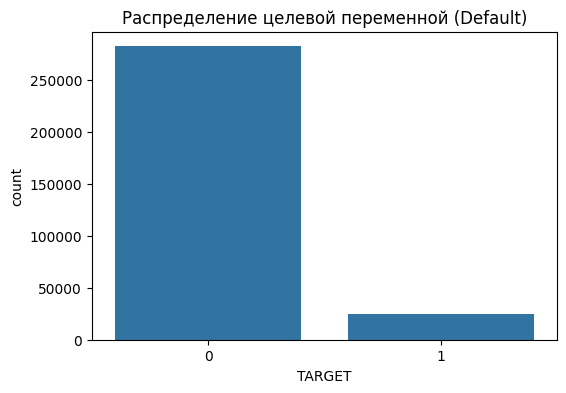

In [4]:
# Визуализируем распределение целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=app_train)
plt.title("Распределение целевой переменной (Default)")

In [5]:
# Попытка отобразить график или сохранить его
if plt.isinteractive():
    plt.show()
else:
    plt.savefig("target_distribution.png")
    print("График сохранён в target_distribution.png")

In [6]:
# Проверяем пропуски
missing_values = app_train.isnull().sum() / len(app_train) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Пропущенные значения (Top 20):\n", missing_values.head(20))

Пропущенные значения (Top 20):
 COMMONAREA_MEDI             69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_AVG              69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
FLOORSMIN_MEDI              67.848630
FLOORSMIN_MODE              67.848630
FLOORSMIN_AVG               67.848630
YEARS_BUILD_MODE            66.497784
YEARS_BUILD_MEDI            66.497784
YEARS_BUILD_AVG             66.497784
OWN_CAR_AGE                 65.990810
LANDAREA_AVG                59.376738
LANDAREA_MEDI               59.376738
LANDAREA_MODE               59.376738
dtype: float64


In [7]:
# Выбираем только числовые признаки для модели
num_features = app_train.select_dtypes(include=[np.number]).drop(columns=["TARGET", "SK_ID_CURR"])

# Заполняем пропуски медианными значениями
imputer = SimpleImputer(strategy='median')
num_features_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)

In [8]:
# Добавляем новые признаки
num_features_imputed['CREDIT_INCOME_RATIO'] = num_features_imputed['AMT_CREDIT'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['ANNUITY_INCOME_RATIO'] = num_features_imputed['AMT_ANNUITY'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['DAYS_EMPLOYED_RATIO'] = num_features_imputed['DAYS_EMPLOYED'] / (num_features_imputed['DAYS_BIRTH'] + 1)

In [9]:
# Масштабируем данные
scaler = StandardScaler()
X = scaler.fit_transform(num_features_imputed)
y = app_train["TARGET"]

In [10]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Обучаем логистическую регрессию
log_reg = LogisticRegression(max_iter=1000, C=1, solver='liblinear')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [12]:
# Предсказания
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [13]:
# Оценка качества модели
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_score:.4f}")
print(classification_report(y_test, y_pred))

AUC-ROC Score: 0.7380
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.56      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



Text(0.5, 1.0, 'Распределение предсказанных вероятностей дефолта')

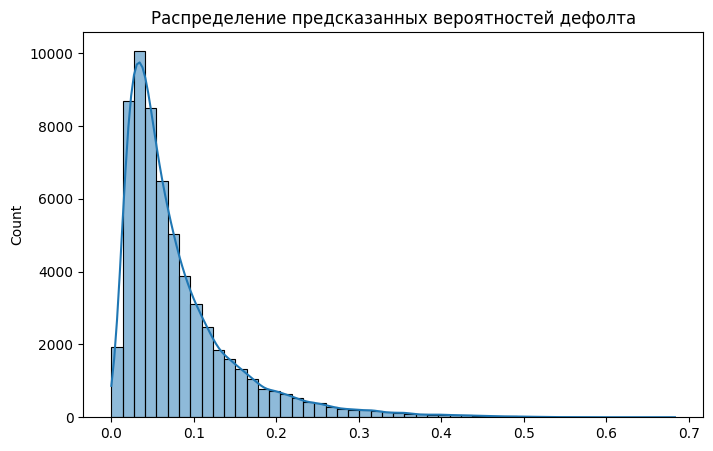

In [14]:
# Визуализация вероятностей предсказаний
plt.figure(figsize=(8, 5))
sns.histplot(y_prob, bins=50, kde=True)
plt.title("Распределение предсказанных вероятностей дефолта")